# Introduction to Neural Networks

First, set up the environment by installing the required packages and importing the necessary functions and classes.

In [1]:
# pip install keras numpy tensorflow sklearn scipy
# conda install keras numpy tensorflow sklearn scipy
from __future__ import print_function

import numpy as np

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

## Download and prepare the data

For this introduction, the classic MNIST dataset of hand-drawn digits is used.  Download the data, reshape it if necessary, and normalize it.

In [2]:
num_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28

# load the data, split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_train shape: (60000, 28, 28)
y_train shape: (60000,)


Image number: 39841


AttributeError: 'AxesSubplot' object has no attribute 'ravel'

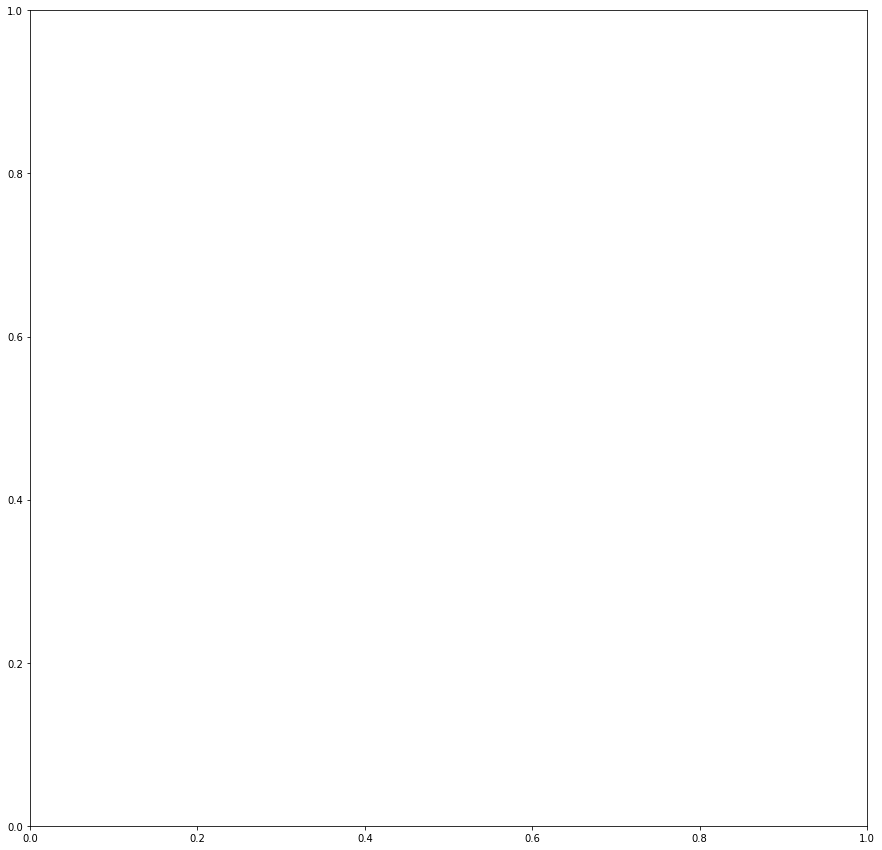

In [13]:
# View the raw data
import matplotlib.pyplot as plt

index = np.random.randint(low=0, high=X_train.shape[0])
print('Image number:', index)

fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_train[index])
ax[0].set_title('Source Image')

ax[1].imshow(y_train[index])
ax[1].set_title('Label Image')

fig.tight_layout()
plt.show()

In [3]:
# Reshape data if necessary
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1) # (batches, rows, cols, channels)

# normalize the data: set pixel values to be in range [0, 1]
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.
X_test /= 255.

print('x_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('First 10 values of y_train:', y_train[:10])

x_train shape: (60000, 28, 28, 1)
y_train shape: (60000,)
First 10 values of y_train: [5 0 4 1 9 2 1 3 1 4]


## Linear Classifier

First, try using a linear classifier with the MNIST data.  Below is an implmentation of a Support Vector Machine from sklearn.

In [4]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

# Our current shape is (batches, rows, cols, channels) but SVC expects (batches, pixels)
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]*X_test.shape[2]))

model = LinearSVC()

model.fit(X_train_reshaped, y_train)

predictions = model.predict(X_test_reshaped)
print(classification_report(y_test, predictions))
print('Accuracy Score:', accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.89      0.91      1032
           3       0.89      0.91      0.90      1010
           4       0.92      0.93      0.92       982
           5       0.89      0.86      0.88       892
           6       0.94      0.95      0.94       958
           7       0.92      0.92      0.92      1028
           8       0.88      0.87      0.87       974
           9       0.90      0.89      0.89      1009

   micro avg       0.92      0.92      0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

Accuracy Score: 0.9183


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Neural Networks
Let's compare our linear classifier results with simple neural networks using Keras.

First, convert the class vectors to binary class matrices or "one-hot encode" the data.

In [5]:
# Using the keras to_categorical function to one-hot encode the data

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print(y_train[:10])

y_train shape: (60000, 10)
y_test shape: (10000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


## Dense Network

First, a basic one-layer example. *(Using the functional model API)*

In [6]:
inputs = Input(shape=input_shape)
model = Sequential()
flat = Flatten()(inputs)
dense = Dense(10, activation='softmax')(flat) # output is softmax(dot(X, W) + bias)
model = Model(inputs=inputs, outputs=dense)

model.compile(loss=categorical_crossentropy,
              optimizer=SGD(momentum=0.9, nesterov=True),
              metrics=['accuracy'])

loss = model.fit(X_train, y_train,
                 batch_size=128,
                 epochs=5,
                 verbose=1,
                 validation_data=(X_test, y_test))

Instructions for updating:
Colocations handled automatically by placer.
Train on 60000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
60000/60000 [==============================] - 1s 11us/sample - loss: 0.5879 - acc: 0.8467 - val_loss: 0.3817 - val_acc: 0.8989
Epoch 2/5
60000/60000 [==============================] - 1s 9us/sample - loss: 0.3752 - acc: 0.8971 - val_loss: 0.3384 - val_acc: 0.9090
Epoch 3/5
60000/60000 [==============================] - 1s 10us/sample - loss: 0.3435 - acc: 0.9046 - val_loss: 0.3169 - val_acc: 0.9120
Epoch 4/5
60000/60000 [==============================] - 1s 9us/sample - loss: 0.3269 - acc: 0.9087 - val_loss: 0.3072 - val_acc: 0.9139
Epoch 5/5
60000/60000 [==============================] - 1s 9us/sample - loss: 0.3163 - acc: 0.9118 - val_loss: 0.3006 - val_acc: 0.9174


## Convolutional Network

5 epochs yield results comparable to the linear classifier, but the neural network can definitely be improved.  Below is a common pattern of Convolutions, Pooling, Dropout, and Dense layers.  [Read more about these layer types on Wikipedia](https://en.wikipedia.org/wiki/Convolutional_neural_network#Design)

In [7]:
model = Sequential()
# 32 3x3 filters (extracting 5x5-pixel subregions), with ReLU activation
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))# Apply max filter to every 2x2 patch
model.add(Dropout(0.25)) # Drop 25% of inputs to prevent overfitting
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss=categorical_crossentropy,
              optimizer=SGD(momentum=0.9, nesterov=True),
              metrics=['accuracy'])

loss = model.fit(X_train, y_train,
                 batch_size=128,
                 epochs=5,
                 verbose=1,
                 validation_data=(X_test, y_test))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 87s 1ms/sample - loss: 0.3229 - acc: 0.9030 - val_loss: 0.1016 - val_acc: 0.9696
Epoch 2/5
60000/60000 [==============================] - 94s 2ms/sample - loss: 0.0937 - acc: 0.9718 - val_loss: 0.0634 - val_acc: 0.9795
Epoch 3/5
60000/60000 [==============================] - 90s 2ms/sample - loss: 0.0635 - acc: 0.9801 - val_loss: 0.0529 - val_acc: 0.9823
Epoch 4/5
60000/60000 [==============================] - 83s 1ms/sample - loss: 0.0488 - acc: 0.9848 - val_loss: 0.0438 - val_acc: 0.9849
Epoch 5/5
60000/60000 [==============================] - 82s 1ms/sample - loss: 0.0400 - acc: 0.9877 - val_loss: 0.0388 - val_acc: 0.9876
